# Adquisicion de lo datos

In [115]:
import requests
import json

# Lista de monedas objetivo
mis_tokens = {
    "kava", "concordium", "harmony", "celer", "nolus",
    "oasys", "stargaze", "hydration", "bitgert", "kadena"
}

# 1. Obtener todas las monedas de CoinGecko
url = "https://api.coingecko.com/api/v3/coins/list"
response = requests.get(url)
all_coins = response.json()

# 2. Filtrar solo las que te interesan
mis_criptos = []
for coin in all_coins:
    if coin["id"] in mis_tokens:
        mis_criptos.append({
            "gecko_id": coin["id"],
            "name": coin["name"],
            "token": coin["symbol"]
        })

# 3. Eliminar duplicados (por si acaso)
unique = {c["gecko_id"]: c for c in mis_criptos}.values()

# 4. Guardar en JSON
with open("criptomonedas.json", "w") as f:
    json.dump(list(unique), f, indent=4)

print("✔️ criptomonedas.json generado correctamente.")


✔️ criptomonedas.json generado correctamente.


In [116]:
import json
import requests
from time import sleep

# 1. Cargar monedas desde el JSON generado en 1stphase
with open("criptomonedas.json", "r") as f:
    tokens = json.load(f)

# 2. Obtener chains de DeFiLlama
llama_url = "https://api.llama.fi/v2/chains"
chains = requests.get(llama_url).json()

# Convertimos los nombres a minúsculas para comparar fácilmente
chain_names = {chain["name"].lower(): chain["name"] for chain in chains}

# 3. Intentar encontrar match por nombre entre CoinGecko y DeFiLlama
tvl_histories = {}

for token in tokens:
    name = token["name"].lower()

    # Buscar el nombre en la lista de chains de DefiLlama
    match = next((llama_name for llama_name in chain_names if llama_name in name), None)
    if not match:
        print(f"No TVL encontrado para {token['name']}")
        continue

    # Llamar al endpoint de historial de TVL
    print(f"Obteniendo TVL para {chain_names[match]}...")
    tvl_url = f"https://api.llama.fi/v2/historicalChainTvl/{chain_names[match]}"
    response = requests.get(tvl_url)

    if response.status_code == 200:
        tvl_histories[token["token"]] = {
            "chain_name": chain_names[match],
            "tvl_history": response.json()
        }
    else:
        print(f"❌ Error con {chain_names[match]}")

    sleep(1.2)  # Para evitar rate limit

# 4. Guardar todo en un JSON
with open("historial_tvl_criptomonedas.json", "w") as f:
    json.dump(tvl_histories, f, indent=4)

print("✔️ historial_tvl_criptomonedas.json guardado con éxito.")


Obteniendo TVL para Concordium...
Obteniendo TVL para Harmony...
Obteniendo TVL para Kadena...
Obteniendo TVL para Kava...
Obteniendo TVL para Nolus...
Obteniendo TVL para Oasys...
Obteniendo TVL para Stargaze...
✔️ historial_tvl_criptomonedas.json guardado con éxito.


In [117]:
import json
import requests
import pandas as pd
from datetime import datetime
from time import sleep

# Nuevo rango de fechas válido (CoinGecko solo permite últimos 365 días)
from_date = int(datetime(2024, 6, 1).timestamp())
to_date = int(datetime(2025, 5, 31).timestamp())

# Headers para evitar 401
headers = {
    "User-Agent": "Mozilla/5.0"
}

# Cargar archivos previos
with open("criptomonedas.json", "r") as f:
    tokens = json.load(f)

with open("historial_tvl_criptomonedas.json", "r") as f:
    tvl_data = json.load(f)

# Convertidor de timestamp a fecha YYYY-MM-DD
def to_date_str(ts):
    return datetime.utcfromtimestamp(ts).strftime("%Y-%m-%d")

rows = []

for token in tokens:
    gecko_id = token["gecko_id"].lower().strip()
    name = token["name"]
    symbol = token["token"]

    url = f"https://api.coingecko.com/api/v3/coins/{gecko_id}/market_chart/range"
    params = {
        "vs_currency": "usd",
        "from": from_date,
        "to": to_date
    }

    print(f"Descargando data de {name}...")
    r = requests.get(url, params=params, headers=headers)
    if r.status_code != 200:
        print(f"❌ Falló {name} ({gecko_id}): {r.status_code}")
        continue

    data = r.json()
    prices = data.get("prices", [])
    market_caps = data.get("market_caps", [])
    volumes = data.get("total_volumes", [])

    # Verificar que tenga suficiente data
    if not prices or not market_caps:
        print(f"⚠️ Sin datos válidos para {name}")
        continue

    df = pd.DataFrame({
        "date": [to_date_str(p[0] // 1000) for p in prices],
        "price": [p[1] for p in prices],
        "market_cap": [mc[1] for mc in market_caps],
        "volume": [v[1] for v in volumes],
    })

    df["token"] = symbol
    df["name"] = name

    # Merge con TVL si existe
    tvl_history = tvl_data.get(symbol, {}).get("tvl_history", [])
    tvl_df = pd.DataFrame(tvl_history)
    if not tvl_df.empty:
        tvl_df["date"] = tvl_df["date"].apply(to_date_str)
        df = df.merge(tvl_df, on="date", how="left")
        df.rename(columns={"tvl": "tvl_usd"}, inplace=True)
    else:
        df["tvl_usd"] = None

    # Métricas derivadas
    df["volume_to_marketcap"] = df["volume"] / df["market_cap"]
    df["price_change_%"] = df["price"].pct_change() * 100
    df["market_cap_trend"] = df["market_cap"].pct_change() * 100
    df["tvl_trend"] = df["tvl_usd"].pct_change() * 100

    # Narrativa
    narrativa = token.get("narrative", "Desconocido")
    df["narrative"] = narrativa

    rows.append(df)
    sleep(1.1)  # evitar rate limit

# Guardar CSV
if rows:
    final_df = pd.concat(rows)
    final_df.dropna(subset=["price", "market_cap"], inplace=True)
    final_df.to_csv("dataset_criptos_2024_2025.csv", index=False)
    print("✅ dataset_criptos_2024_2025.csv guardado con éxito.")
else:
    print("❌ No se pudo generar el dataset. Verifica los gecko_id y la conexión.")


Descargando data de Concordium...


C:\Users\rosar\AppData\Local\Temp\ipykernel_14604\521250748.py:25: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  return datetime.utcfromtimestamp(ts).strftime("%Y-%m-%d")
C:\Users\rosar\AppData\Local\Temp\ipykernel_14604\521250748.py:25: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  return datetime.utcfromtimestamp(ts).strftime("%Y-%m-%d")


Descargando data de Harmony...


C:\Users\rosar\AppData\Local\Temp\ipykernel_14604\521250748.py:25: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  return datetime.utcfromtimestamp(ts).strftime("%Y-%m-%d")
C:\Users\rosar\AppData\Local\Temp\ipykernel_14604\521250748.py:25: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  return datetime.utcfromtimestamp(ts).strftime("%Y-%m-%d")


Descargando data de Kadena...


C:\Users\rosar\AppData\Local\Temp\ipykernel_14604\521250748.py:25: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  return datetime.utcfromtimestamp(ts).strftime("%Y-%m-%d")
C:\Users\rosar\AppData\Local\Temp\ipykernel_14604\521250748.py:25: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  return datetime.utcfromtimestamp(ts).strftime("%Y-%m-%d")


Descargando data de Kava...


C:\Users\rosar\AppData\Local\Temp\ipykernel_14604\521250748.py:25: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  return datetime.utcfromtimestamp(ts).strftime("%Y-%m-%d")
C:\Users\rosar\AppData\Local\Temp\ipykernel_14604\521250748.py:25: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  return datetime.utcfromtimestamp(ts).strftime("%Y-%m-%d")


Descargando data de Nolus...


C:\Users\rosar\AppData\Local\Temp\ipykernel_14604\521250748.py:25: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  return datetime.utcfromtimestamp(ts).strftime("%Y-%m-%d")
C:\Users\rosar\AppData\Local\Temp\ipykernel_14604\521250748.py:25: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  return datetime.utcfromtimestamp(ts).strftime("%Y-%m-%d")


Descargando data de Oasys...
❌ Falló Oasys (oasys): 429
Descargando data de Stargaze...
❌ Falló Stargaze (stargaze): 429
✅ dataset_criptos_2024_2025.csv guardado con éxito.


# Preprocesamiento de los datos

In [118]:
# Cargar datos 
data =  pd.read_csv(r"C:\Users\rosar\RufoEsEterno\MachineLearning\TrabajoParcial\criptodataset.csv")

In [119]:
data.describe()

,price,market_cap,volume,tvl_usd,volume_to_marketcap,price_change_%,market_cap_trend,tvl_trend
count,1740.000000,1.740000e+03,1.740000e+03,1.740000e+03,1740.000000,1735.000000,1735.000000,1735.000000
mean,0.224612,1.777126e+08,1.127639e+07,3.309387e+07,0.048381,-0.161313,-0.103440,0.339615
std,0.295149,1.808609e+08,2.096859e+07,6.502968e+07,0.057917,5.096132,5.098647,11.335973
min,0.000983,2.635667e+06,1.011485e+03,7.246400e+04,0.000199,-20.419520,-20.265189,-68.589293
25%,0.010654,9.298688e+06,1.233864e+05,3.205822e+05,0.010254,-2.721573,-2.741799,-2.811987
50%,0.016684,1.505689e+08,6.025160e+06,1.133220e+06,0.035491,-0.253257,-0.156880,0.000000
75%,0.453352,2.947722e+08,1.344001e+07,2.455542e+06,0.063734,2.098528,2.180865,2.352405
max,1.853151,7.748413e+08,3.250321e+08,2.217892e+08,0.843553,44.344404,44.223039,223.317782


In [120]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1740 entries, 0 to 1739
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 1740 non-null   object 
 1   price                1740 non-null   float64
 2   market_cap           1740 non-null   float64
 3   volume               1740 non-null   float64
 4   token                1740 non-null   object 
 5   name                 1740 non-null   object 
 6   tvl_usd              1740 non-null   int64  
 7   volume_to_marketcap  1740 non-null   float64
 8   price_change_%       1735 non-null   float64
 9   market_cap_trend     1735 non-null   float64
 10  tvl_trend            1735 non-null   float64
 11  narrative            1740 non-null   object 
dtypes: float64(7), int64(1), object(4)
memory usage: 163.3+ KB


### Verificacion de valores nulos y duplicados

In [121]:

print(data.isnull().sum())

date                   0
price                  0
market_cap             0
volume                 0
token                  0
name                   0
tvl_usd                0
volume_to_marketcap    0
price_change_%         5
market_cap_trend       5
tvl_trend              5
narrative              0
dtype: int64


In [122]:
'''
Los nulos de son los primeros registros de cada token por lo que los vamos a dropear 
'''

# Eliminar esas 5 filas nulas (no afecta la calidad del dataset)
data = data.dropna(subset=["price_change_%", "market_cap_trend", "tvl_trend"])


In [123]:
print(data.isnull().sum())

date                   0
price                  0
market_cap             0
volume                 0
token                  0
name                   0
tvl_usd                0
volume_to_marketcap    0
price_change_%         0
market_cap_trend       0
tvl_trend              0
narrative              0
dtype: int64


In [124]:
print(data.duplicated().sum())

0


In [125]:
'''
Borramos la columna narrative ya que no aporta nada al modelo
todos los valores son "desconocido"
'''

data.drop(columns=["narrative"],inplace=True)

In [126]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1735 entries, 1 to 1739
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 1735 non-null   object 
 1   price                1735 non-null   float64
 2   market_cap           1735 non-null   float64
 3   volume               1735 non-null   float64
 4   token                1735 non-null   object 
 5   name                 1735 non-null   object 
 6   tvl_usd              1735 non-null   int64  
 7   volume_to_marketcap  1735 non-null   float64
 8   price_change_%       1735 non-null   float64
 9   market_cap_trend     1735 non-null   float64
 10  tvl_trend            1735 non-null   float64
dtypes: float64(7), int64(1), object(3)
memory usage: 162.7+ KB


### Outliers

<Axes: >

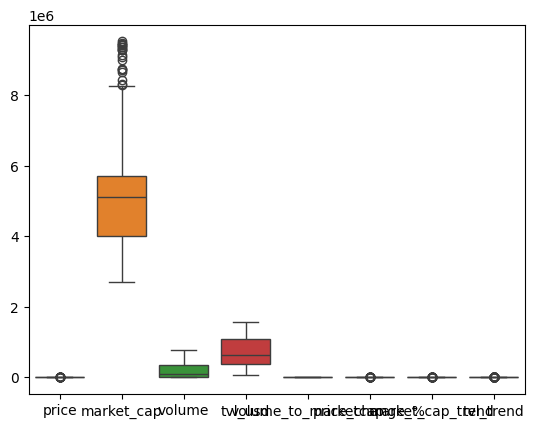

In [127]:
import seaborn as sns

sns.boxplot(df,)

In [128]:
def detectar_outliers_iqr(df, columna):
    q1 = df[columna].quantile(0.25)
    q3 = df[columna].quantile(0.75)
    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = df[(df[columna] < lower_bound) | (df[columna] > upper_bound)]

    print(f"{len(outliers)} outliers encontrados en '{columna}'")
    print(outliers[["date", "token", columna]].sort_values(by=columna, ascending=False))

    return outliers, lower_bound, upper_bound


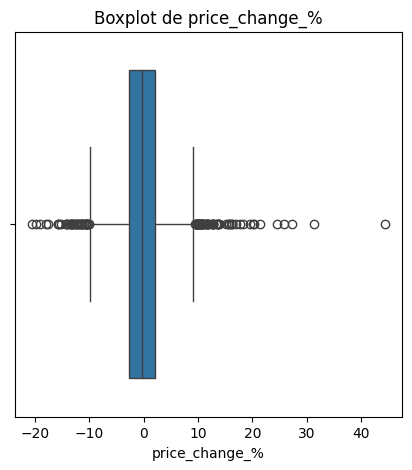

In [129]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
sns.boxplot(x=data["price_change_%"])
plt.title("Boxplot de price_change_%")
plt.show()


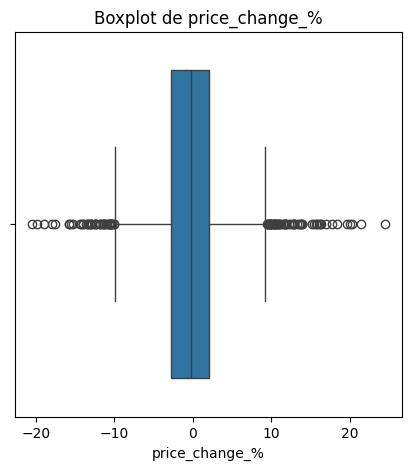

In [130]:
'''
En cripto es normal tener algunos días con +30% o -25%, sobre todo en tokens pequeños. 
Pero si estamos armando un modelo para detectar valorizaciones sostenidas, no queremos que esos outliers extremos distorsionen los patrones base.
'''

# Limitar cambios extremos de precio diario
data = data[data["price_change_%"].between(-25, 25)]
plt.figure(figsize=(5, 5))
sns.boxplot(x=data["price_change_%"])
plt.title("Boxplot de price_change_%")
plt.show()

In [131]:
print(detectar_outliers_iqr(data, "volume_to_marketcap"))

75 outliers encontrados en 'volume_to_marketcap'
            date token  volume_to_marketcap
177   2024-11-25   one             0.843553
190   2024-12-08   one             0.576021
176   2024-11-24   one             0.498397
526   2024-11-26   kda             0.463556
459   2024-09-20   kda             0.425532
...          ...   ...                  ...
579   2025-01-18   kda             0.149292
542   2024-12-12   kda             0.148485
196   2024-12-14   one             0.146684
595   2025-02-03   kda             0.145533
1002  2025-04-03  kava             0.145453

[75 rows x 3 columns]
(            date     price    market_cap        volume token     name  \
66    2024-08-06  0.009995  1.229904e+08  3.531778e+07   one  Harmony   
171   2024-11-19  0.016117  1.982632e+08  3.797290e+07   one  Harmony   
175   2024-11-23  0.017207  2.115986e+08  5.992758e+07   one  Harmony   
176   2024-11-24  0.020892  2.568145e+08  1.279957e+08   one  Harmony   
177   2024-11-25  0.024436  3.0070

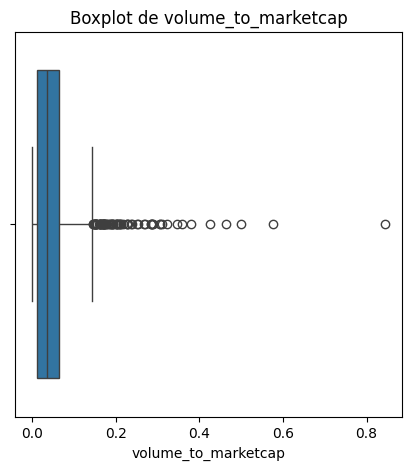

In [132]:
plt.figure(figsize=(5, 5))
sns.boxplot(x=data["volume_to_marketcap"])
plt.title("Boxplot de volume_to_marketcap")
plt.show()

In [133]:

'''
Si el valor es bajo (0.01 - 0.1) → poco movimiento, baja especulación.

Si es moderado (0.1 - 0.3) → volumen saludable.

Si es alto (> 0.5) → puede ser:

    Un pump temporal 

    Un dato distorsionado por error de API

    Manipulación de mercado
'''

data = data[data["volume_to_marketcap"] <= 0.5]


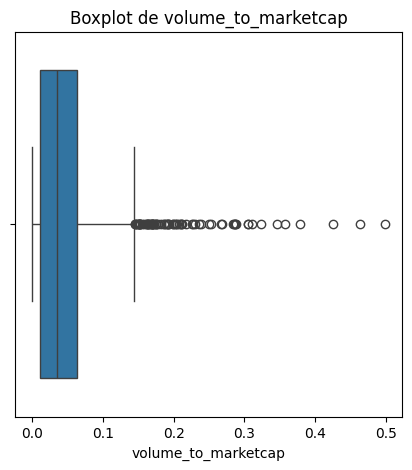

In [134]:
plt.figure(figsize=(5, 5))
sns.boxplot(x=data["volume_to_marketcap"])
plt.title("Boxplot de volume_to_marketcap")
plt.show()

In [135]:
print(detectar_outliers_iqr(data, "market_cap_trend"))

99 outliers encontrados en 'market_cap_trend'
            date  token  market_cap_trend
944   2025-02-04   kava         24.058453
176   2024-11-24    one         21.368736
1406  2024-06-15  stars         20.180217
579   2025-01-18    kda         20.095952
206   2024-12-24    one         19.421700
...          ...    ...               ...
1413  2024-06-22  stars        -16.664646
540   2024-12-10    kda        -17.343586
1407  2024-06-16  stars        -19.082546
192   2024-12-10    one        -19.896770
888   2024-12-10   kava        -20.265189

[99 rows x 3 columns]
(            date     price    market_cap        volume  token      name  \
7     2024-06-08  0.020002  2.462028e+08  1.291264e+07    one   Harmony   
36    2024-07-07  0.013126  1.612959e+08  3.587827e+06    one   Harmony   
69    2024-08-09  0.011410  1.405874e+08  8.510824e+06    one   Harmony   
84    2024-08-24  0.013307  1.637470e+08  1.010608e+07    one   Harmony   
147   2024-10-26  0.012041  1.480922e+08  8.387715e

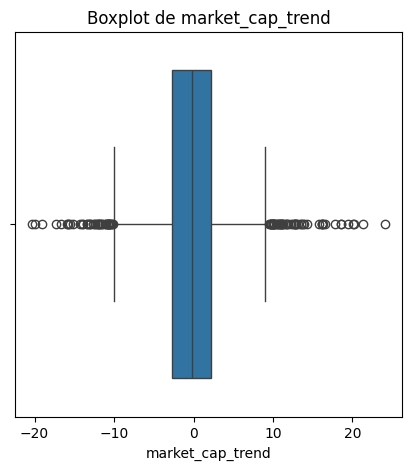

In [136]:
plt.figure(figsize=(5, 5))
sns.boxplot(x=data["market_cap_trend"])
plt.title("Boxplot de market_cap_trend")
plt.show()

In [137]:
'''
Los valores fuera del rango están entre +24% y -20% de cambio diario en market cap.

Esto puede pasar por:

    Saltos de volumen (por hype)

    Cambios bruscos en circulante (ajustes del supply)

    Errores de scraping

En monedas chicas, un 10% de cambio diario es normal, pero 20%+ puede meter mucho ruido si 
no es constante.
'''

# Limpiar cambios extremos de market cap
data = data[data["market_cap_trend"].between(-20, 20)]


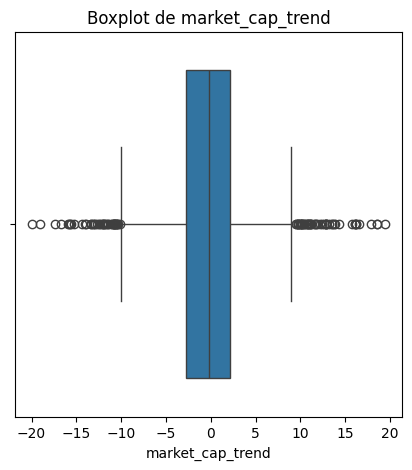

In [138]:
plt.figure(figsize=(5, 5))
sns.boxplot(x=data["market_cap_trend"])
plt.title("Boxplot de market_cap_trend")
plt.show()

In [139]:
print(detectar_outliers_iqr(data, "tvl_trend"))

213 outliers encontrados en 'tvl_trend'
            date  token   tvl_trend
1292  2025-02-04    nls  223.317782
1291  2025-02-03    nls  201.534848
452   2024-09-13    kda   82.456405
1546  2024-11-02  stars   70.047431
1246  2024-12-20    nls   62.524709
...          ...    ...         ...
123   2024-10-02    one  -30.076589
1237  2024-12-11    nls  -34.004010
1281  2025-01-24    nls  -45.145832
1275  2025-01-18    nls  -63.526775
1322  2025-03-06    nls  -68.589293

[213 rows x 3 columns]
(            date     price    market_cap        volume  token      name  \
4     2024-06-05  0.022940  2.822307e+08  6.750956e+06    one   Harmony   
6     2024-06-07  0.022480  2.764813e+08  4.946630e+06    one   Harmony   
7     2024-06-08  0.020002  2.462028e+08  1.291264e+07    one   Harmony   
14    2024-06-15  0.016718  2.057806e+08  6.583679e+06    one   Harmony   
20    2024-06-21  0.015312  1.885975e+08  6.162124e+06    one   Harmony   
...          ...       ...           ...           ..

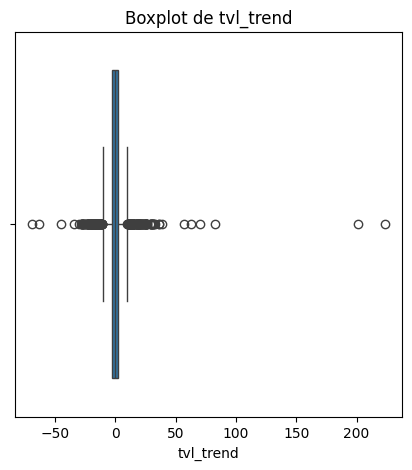

In [140]:
plt.figure(figsize=(5, 5))
sns.boxplot(x=data["tvl_trend"])
plt.title("Boxplot de tvl_trend")
plt.show()

In [141]:
'''
Tienes outliers fuertes:

    +223% de subida en TVL en un solo día

    -68% de bajada en otro

Valores normales parecen estar entre -10% y +10%

El IQR (rango intercuartílico) es:

    Q1 ≈ -10.61

    Q3 ≈ +10.08

    IQR ≈ 20.69

Pero el boxplot se rompe por esos saltos locos, especialmente del token nls
'''

# Eliminar saltos absurdos de TVL (más de ±25% diario)
data = data[data["tvl_trend"].between(-25, 25)]


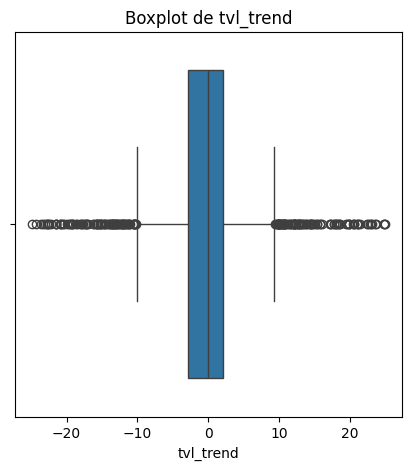

In [142]:
plt.figure(figsize=(5, 5))
sns.boxplot(x=data["tvl_trend"])
plt.title("Boxplot de tvl_trend")
plt.show()

### Transformaciones logaritmicas

In [143]:
import numpy as np

In [144]:
# Aplicamos transformación logarítmica con np.log1p() a las siguientes columnas:
# - price
# - market_cap
# - volume
# - tvl_usd
# Estas variables representan magnitudes monetarias (positivas y altamente sesgadas),
# lo que significa que pueden tener una escala muy amplia (desde miles hasta cientos de millones).
# Al aplicar log1p, comprimimos la escala y reducimos el impacto de valores extremos,
# haciendo que los modelos de ML aprendan de manera más balanceada.

# No aplicamos log a columnas como:
# - price_change_%, market_cap_trend, tvl_trend
# Porque ya son variables derivadas que expresan cambio porcentual (pueden ser negativas).
# El logaritmo no es válido para valores negativos y además no es necesario transformar estos porcentajes.

data["log_price"] = np.log1p(data["price"])
data["log_market_cap"] = np.log1p(data["market_cap"])
data["log_volume"] = np.log1p(data["volume"])
data["log_tvl_usd"] = np.log1p(data["tvl_usd"])

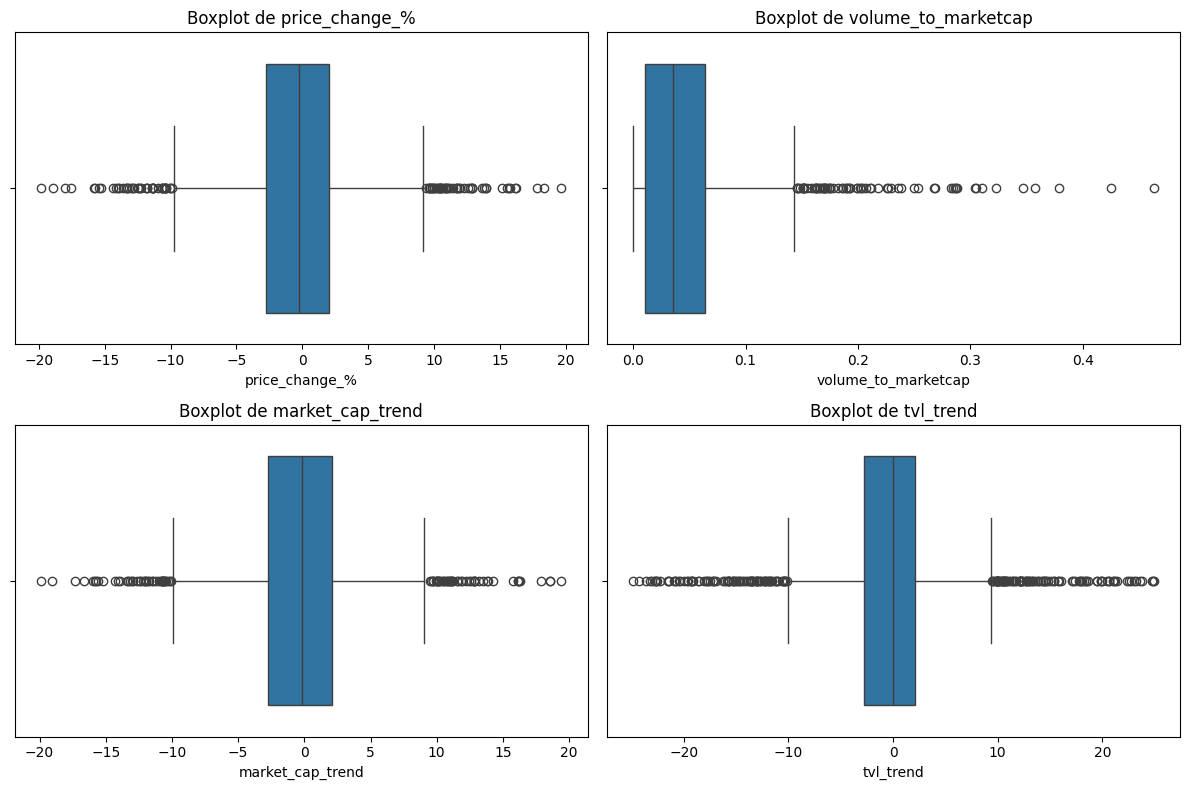

In [145]:
# Columnas a graficar
cols = ["price_change_%", "volume_to_marketcap", "market_cap_trend", "tvl_trend"]

# Crear subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()

# Plotear cada boxplot
for i, col in enumerate(cols):
    sns.boxplot(x=data[col], ax=axes[i])
    axes[i].set_title(f"Boxplot de {col}")

plt.tight_layout()
plt.show()

### Creacion de columnas

In [146]:
'''
Este será tu target para clasificación, donde etiquetas si un token tuvo un incremento 
de precio superior a cierto umbral.
'''
# Etiqueta si el precio sube más de 5% al día
data["price_increase_label"] = (data["price_change_%"] > 5).astype(int)


In [147]:
'''
Mide cuán volátil ha sido el precio en los últimos días. Vamos con 7 días como ejemplo
'''
# Convertir fecha a datetime para poder agrupar correctamente
data["date"] = pd.to_datetime(data["date"])

# Calcular rolling std por token (ventana de 7 días)
data = data.sort_values(by=["token", "date"])
data["price_volatility"] = data.groupby("token")["price"].transform(lambda x: x.pct_change().rolling(window=7).std())


In [148]:
# Suma simple de señales de impulso
data["trend_score"] = (
    data["price_change_%"].fillna(0) +
    data["market_cap_trend"].fillna(0) +
    data["tvl_trend"].fillna(0)
)


In [149]:
data.head()

,date,price,market_cap,volume,token,name,tvl_usd,volume_to_marketcap,price_change_%,market_cap_trend,tvl_trend,log_price,log_market_cap,log_volume,log_tvl_usd,price_increase_label,price_volatility,trend_score
697,2024-06-02,0.654585,7.089477e+08,6.660198e+06,kava,Kava,207251699,0.009394,0.190726,0.146635,-6.002434,0.503550,20.379292,15.711660,19.149445,0,NaN,-5.665072
698,2024-06-03,0.655937,7.098716e+08,8.866538e+06,kava,Kava,204775940,0.012490,0.206586,0.130319,-1.194566,0.504367,20.380595,15.997795,19.137427,0,NaN,-0.857661
699,2024-06-04,0.656083,7.106419e+08,8.156310e+06,kava,Kava,214672150,0.011477,0.022213,0.108506,4.832702,0.504455,20.381679,15.914303,19.184623,0,NaN,4.963420
700,2024-06-05,0.679129,7.335175e+08,9.557920e+06,kava,Kava,219370364,0.013030,3.512770,3.219001,2.188553,0.518275,20.413362,16.072881,19.206272,0,NaN,8.920324
701,2024-06-06,0.694595,7.513304e+08,1.387565e+07,kava,Kava,221528413,0.018468,2.277271,2.428428,0.983747,0.527444,20.437356,16.445646,19.216061,0,NaN,5.689446


In [150]:
data.describe()

,date,price,market_cap,volume,tvl_usd,volume_to_marketcap,price_change_%,market_cap_trend,tvl_trend,log_price,log_market_cap,log_volume,log_tvl_usd,price_increase_label,price_volatility,trend_score
count,1680,1680.000000,1.680000e+03,1.680000e+03,1.680000e+03,1680.000000,1680.000000,1680.000000,1680.000000,1680.000000,1680.000000,1680.000000,1680.000000,1680.000000,1645.000000,1680.000000
mean,2024-11-22 13:25:42.857143040,0.227281,1.784903e+08,1.066533e+07,3.387541e+07,0.046964,-0.309599,-0.251965,-0.262806,0.179859,17.987254,14.353620,14.450015,0.111310,0.044151,-0.824371
min,2024-06-02 00:00:00,0.000983,2.635667e+06,1.011485e+03,7.246400e+04,0.000199,-19.841951,-19.896770,-24.812475,0.000983,14.784647,6.920163,11.190859,0.000000,0.002407,-54.825909
25%,2024-08-27 00:00:00,0.010609,9.343238e+06,1.245888e+05,3.228390e+05,0.010300,-2.729706,-2.742850,-2.797204,0.010553,16.050160,11.732780,12.684912,0.000000,0.028595,-8.086466
50%,2024-11-22 00:00:00,0.017340,1.514101e+08,6.025160e+06,1.115322e+06,0.035533,-0.275517,-0.188233,0.000000,0.017192,18.835502,15.611454,13.924654,0.000000,0.040432,-0.668186
75%,2025-02-19 00:00:00,0.454581,2.994198e+08,1.349255e+07,2.474032e+06,0.063846,2.039698,2.115966,2.077311,0.374718,19.517357,16.417648,14.721358,0.000000,0.055619,6.311350
max,2025-05-14 00:00:00,1.853151,7.748413e+08,1.603097e+08,2.217892e+08,0.463556,19.658055,19.421700,24.936312,1.048424,20.468169,18.892618,19.217238,1.000000,0.177814,55.350863
std,NaN,0.293158,1.811858e+08,1.697096e+07,6.554721e+07,0.049568,4.658280,4.663177,6.374792,0.216730,1.780101,2.630876,2.458232,0.314609,0.025000,13.185594


### Normalizacion

In [151]:
logs = [
    "log_price",
    "log_market_cap",
    "log_volume",
    "log_tvl_usd",
    "volume_to_marketcap",
    "price_volatility",
    "trend_score"
]

In [152]:
from sklearn.preprocessing import StandardScaler

scaled_tokens = {}
for token in data["token"].unique():
    df_token = data[data["token"] == token].copy()
    df_token[logs] = StandardScaler().fit_transform(df_token[logs])
    scaled_tokens[token] = df_token



In [153]:
data_scaled = pd.concat(scaled_tokens.values(), ignore_index=True)

## Graficos

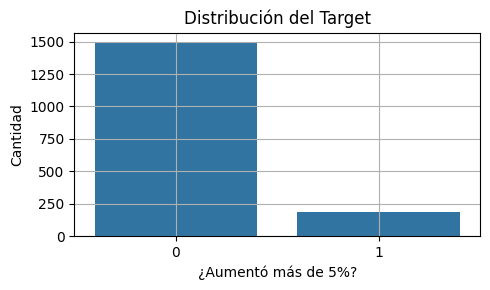

In [154]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 3))
sns.countplot(x="price_increase_label", data=data_scaled)
plt.title("Distribución del Target")
plt.xlabel("¿Aumentó más de 5%?")
plt.ylabel("Cantidad")
plt.grid(True)
plt.tight_layout()
plt.show()




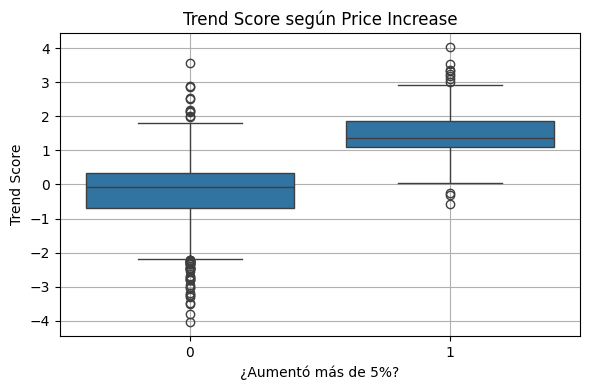

In [155]:
# 2. Trend Score vs Price Increase Label
plt.figure(figsize=(6, 4))
sns.boxplot(x="price_increase_label", y="trend_score", data=data_scaled)
plt.title("Trend Score según Price Increase")
plt.xlabel("¿Aumentó más de 5%?")
plt.ylabel("Trend Score")
plt.grid(True)
plt.tight_layout()
plt.show()


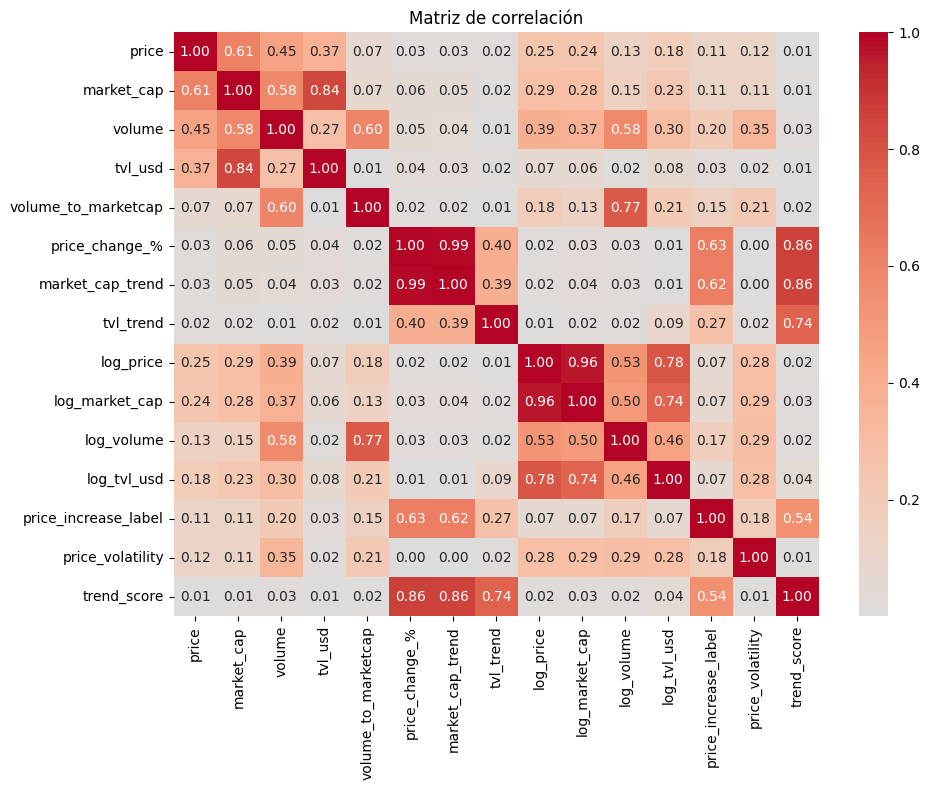

In [156]:
# 3. Volatilidad vs Price Increase Label
plt.figure(figsize=(10, 8))
corr = data_scaled.select_dtypes(include="number").corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Matriz de correlación")
plt.tight_layout()
plt.show()


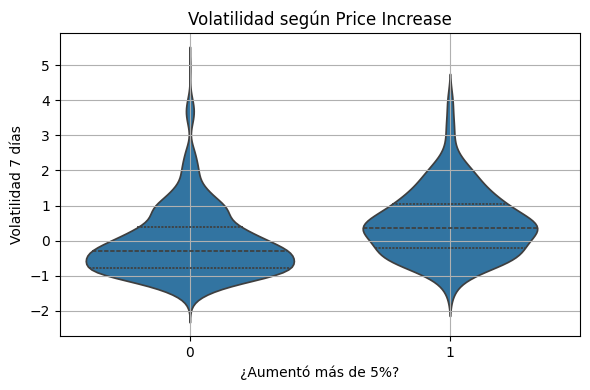

In [157]:
plt.figure(figsize=(6, 4))
sns.violinplot(x="price_increase_label", y="price_volatility", data=data_scaled, inner="quartile")
plt.title("Volatilidad según Price Increase")
plt.xlabel("¿Aumentó más de 5%?")
plt.ylabel("Volatilidad 7 días")
plt.grid(True)
plt.tight_layout()
plt.show()


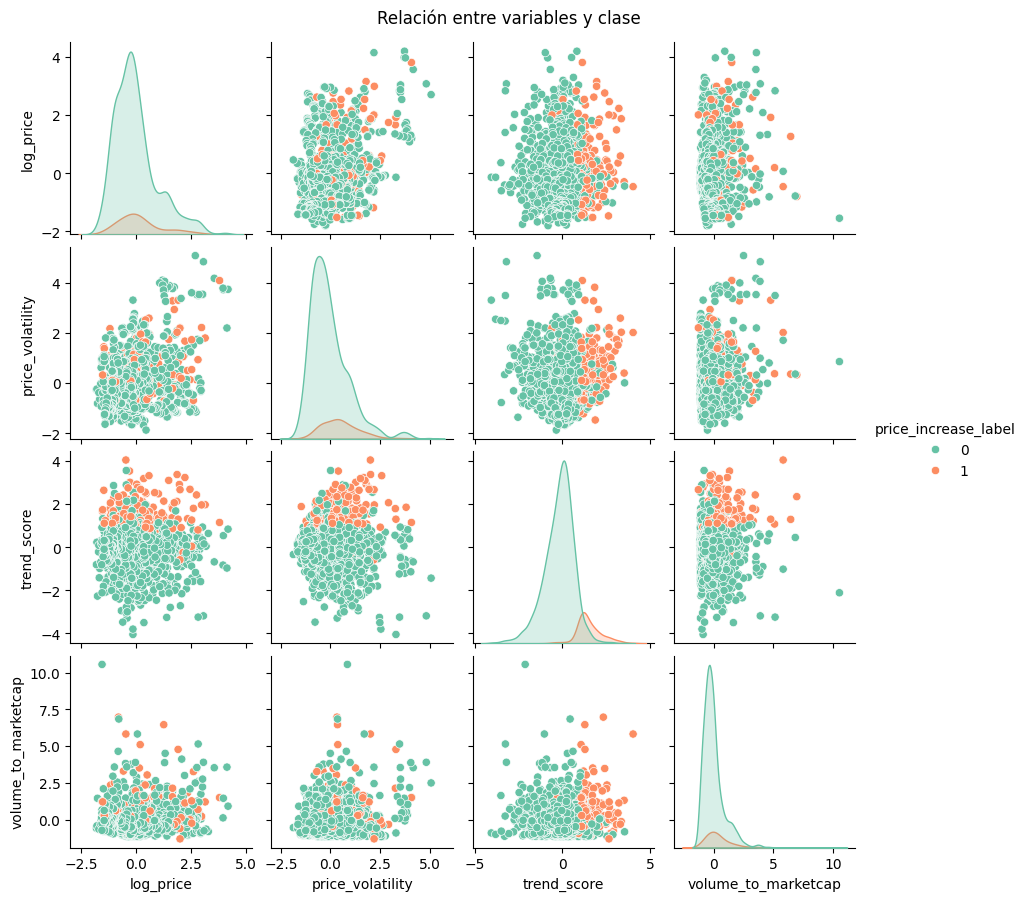

In [158]:
sns.pairplot(
    data_scaled,
    vars=["log_price", "price_volatility", "trend_score", "volume_to_marketcap"],
    hue="price_increase_label",
    palette="Set2",
    height=2.2
)
plt.suptitle("Relación entre variables y clase", y=1.02)
plt.show()


In [159]:
data_scaled.to_csv("dataset_final_preprocesado.csv", index=False)